In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

C:\Users\wlyip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# create a class to represent dataset
class TGSSaltDataset(tf.data.Dataset):
    
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        file_id = self.file_list[index]
        # image folder + path
        image_folder = os.path.join(self.root_path, 'images')
        image_path = os.path.join(image_folder, file_id + '.png')
        
        # label folder + path
        mask_folder = os.path.join(self.root_path, 'masks')
        mask_path = os.path.join(mask_folder, file_id + '.png')
        
        # read it
        image = np.array(cv2.imread(image_path), dtype=np.uint8)
        mask = np.array(cv2.imread(mask_path), dtype=np.uint8)
        
        return image, mask

In [5]:
# init new class dataset
train_mask = pd.read_csv('datasets/train.csv')
depth = pd.read_csv('datasets/depths.csv')

train_path = 'datasets/train'

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)

In [6]:
# function to visualize the images
def plot2x2array(image, mask):
    # invoke matplotlib
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

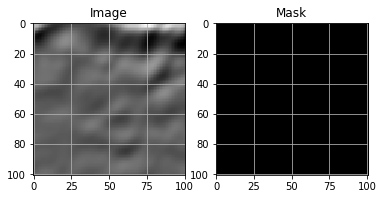

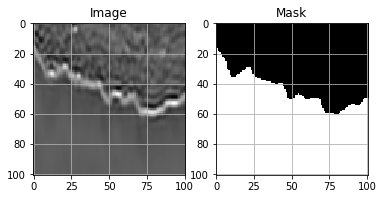

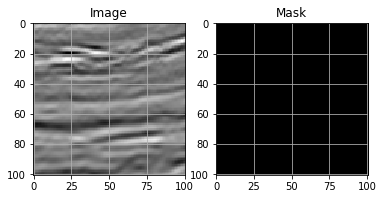

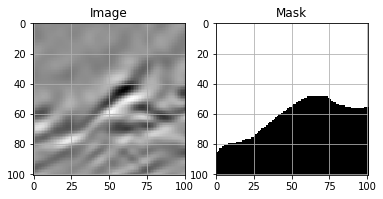

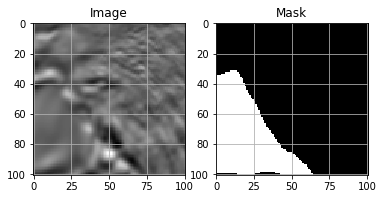

In [7]:
# print the images
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2array(image, mask)

It's hard to distinguish regions of salt from the images.

Text(0.5,1,'depth distribution')

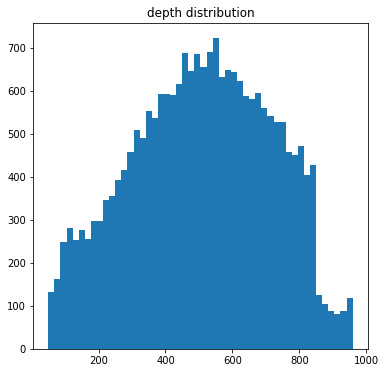

In [8]:
# plot the distribution of depths
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('depth distribution')

Looked like normally distributed.

In [9]:
# convert run length encoding to images that can be input into model
def rleToMask(rleString, height, width):
    rows, cols = height, width
    try:
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rlePairs:
            index -= 1
            img[index:index+length] = 255
            
        # flip the colour black and white    
        img = img.reshape(cols, rows)
        img = img.T
        
    except:
        img = np.zeros((cols, rows))
        
    return img

In [10]:
# function for measuring how salty an image is
def salt_proportion(imgArray):
    try:
        unique, counts = np.unique(imgArray, return_counts=True)
        return counts[1]/10201.
    
    except:
        return 0.0

In [11]:
# prepare to merge depth
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101, 101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [12]:
# merge it
merged = train_mask.merge(depth, how='left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt vs depth')

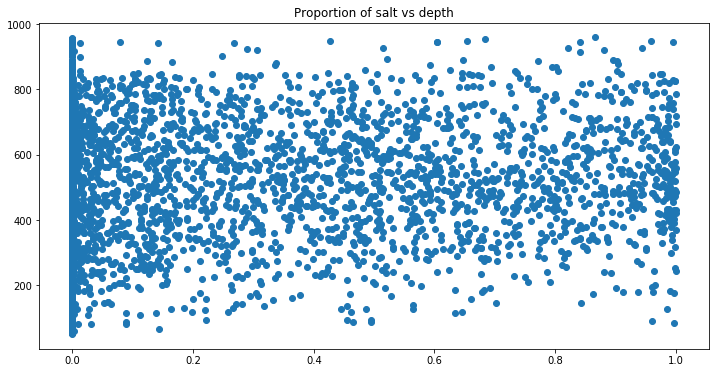

In [13]:
# show proportion of salt vs depth
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt vs depth')

In [14]:
# correlation
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])

Correlation:  0.10361580365557439


Proportion of salt is not correlated to depth?<br>
Lots of points in proportion = 0.